In [164]:
import tensorflow as tf
import keras
import time

In [165]:
from __future__ import print_function
import numpy as np
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

In [166]:
from keras import backend as back
from keras.models import Model
from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b

In [247]:
content_image = Image.open('index.jpeg')
content_image = content_image.resize((512,512))
print(content_image)


<PIL.Image.Image image mode=RGB size=512x512 at 0x7F8003A37A58>


In [248]:
style_image = Image.open('picasso.jpg')
style_image = style_image.resize((512,512))
print(style_image)

<PIL.Image.Image image mode=RGB size=512x512 at 0x7F8003A37588>


In [249]:
print(content_image.size)
print(style_image.size)

(512, 512)
(512, 512)


In [250]:
content_array = np.asarray(content_image, dtype ='float32')
content_array = np.expand_dims(content_array, axis =0)
#temp_array=np.asarray(content_array,dtype='float32')
print(content_array)

[[[[  77.   33.   20.]
   [  77.   33.   20.]
   [  80.   31.   16.]
   ..., 
   [ 154.   73.   69.]
   [ 181.   93.   89.]
   [ 181.   93.   89.]]

  [[  77.   33.   20.]
   [  77.   33.   20.]
   [  80.   31.   16.]
   ..., 
   [ 154.   73.   69.]
   [ 181.   93.   89.]
   [ 181.   93.   89.]]

  [[  77.   33.   20.]
   [  77.   33.   20.]
   [  80.   31.   16.]
   ..., 
   [ 154.   73.   69.]
   [ 181.   93.   89.]
   [ 181.   93.   89.]]

  ..., 
  [[ 214.  140.  155.]
   [ 214.  140.  155.]
   [ 177.  114.  125.]
   ..., 
   [ 164.  113.   70.]
   [ 129.   73.   38.]
   [ 129.   73.   38.]]

  [[ 214.  140.  155.]
   [ 214.  140.  155.]
   [ 177.  114.  125.]
   ..., 
   [ 164.  113.   70.]
   [ 129.   73.   38.]
   [ 129.   73.   38.]]

  [[ 214.  140.  155.]
   [ 214.  140.  155.]
   [ 177.  114.  125.]
   ..., 
   [ 164.  113.   70.]
   [ 129.   73.   38.]
   [ 129.   73.   38.]]]]


In [251]:
print(content_array.shape)

(1, 512, 512, 3)


In [252]:
style_array = np.asarray(style_image, dtype ='float32')
style_array = np.expand_dims(style_array, axis =0)
print(style_array)

[[[[  52.   72.   79.]
   [  46.   66.   75.]
   [  38.   58.   67.]
   ..., 
   [ 105.  113.  102.]
   [  93.  101.   90.]
   [  97.  103.   93.]]

  [[  43.   63.   70.]
   [  39.   59.   66.]
   [  34.   54.   63.]
   ..., 
   [  96.  104.   93.]
   [  95.  103.   92.]
   [  98.  104.   94.]]

  [[  34.   54.   61.]
   [  39.   59.   66.]
   [  40.   60.   69.]
   ..., 
   [ 106.  114.  103.]
   [  95.  101.   91.]
   [  96.  102.   92.]]

  ..., 
  [[  37.   55.   57.]
   [  41.   59.   61.]
   [  41.   59.   61.]
   ..., 
   [  33.   47.   47.]
   [  35.   49.   49.]
   [  35.   49.   49.]]

  [[  34.   52.   54.]
   [  40.   58.   60.]
   [  43.   61.   63.]
   ..., 
   [  34.   50.   49.]
   [  31.   47.   46.]
   [  31.   47.   46.]]

  [[  36.   51.   54.]
   [  43.   58.   61.]
   [  45.   60.   63.]
   ..., 
   [  34.   50.   49.]
   [  28.   44.   43.]
   [  28.   44.   43.]]]]


In [253]:
print(style_array.shape)

(1, 512, 512, 3)


In [254]:
content_array[:,:,:,0] -= 103.989
content_array[:,:,:, 1] -= 116.779
content_array[:,:,:, 2] -= 123.68
content_array = content_array[:,:,:,::-1]

In [255]:
style_array[:,:,:,0] -= 103.989
style_array[:,:,:, 1] -= 116.779
style_array[:,:,:, 2] -= 123.68
style_array = style_array[:,:,:,::-1]

In [256]:
height=512
width=512
content_image = back.variable(content_array)
style_image = back.variable(style_array)
combined_image = back.placeholder((1,height,width,3))

In [257]:
input_to_model = back.concatenate([content_image,style_image,combined_image],axis=0)

In [258]:
model= VGG16(input_tensor=input_to_model,weights='imagenet',include_top=False)

In [259]:
layers= dict([(layer.name,layer.output) for layer in model.layers ])
print(layers)

{'input_6': <tf.Tensor 'concat_5:0' shape=(3, 512, 512, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1_5/Relu:0' shape=(3, 512, 512, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2_5/Relu:0' shape=(3, 512, 512, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool_5/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1_5/Relu:0' shape=(3, 256, 256, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2_5/Relu:0' shape=(3, 256, 256, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool_5/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1_5/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2_5/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3_5/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_pool': <tf.Tensor 'block3_pool_5/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>, 'block4

In [260]:
content_weight= 0.035
style_weight= 5.0
total_variation_weight= 1.0

In [261]:
loss= back.variable(0.)

In [262]:
def content_loss(content, combined):
    return back.sum(back.square(combined-content))

In [263]:
layer_features= layers['block4_conv2']
content_image_features= layer_features[0,:,:,:]
combined_features= layer_features[2,:,:,:]

In [264]:
def gram_matrix(x):
    features= back.batch_flatten(back.permute_dimensions(x,(2,0,1)))
    gram= back.dot(features, back.transpose(features))
    return gram

In [265]:
def style_loss(style,combined):
    s= gram_matrix(style)
    c= gram_matrix(combined)
    channel= 3
    size= height*width
    return back.sum(back.square(s-c)/(4.*(channel**2)*(size**2)))

In [266]:
feature_layers= ['block1_conv2', 'block2_conv2','block3_conv1','block3_conv2', 'block3_conv3','block4_conv1','block4_conv2', 'block4_conv3','block5_conv3']

In [267]:
for layer_name in feature_layers:
    layer_features= layers[layer_name]
    style_features= layer_features[1,:,:,:]
    combined_features= layer_features[2,:,:,:]
    sl= style_loss(style_features,combined_features)
    loss+= (style_weight/len(feature_layers))*sl

In [268]:
def total_variation_loss(x):
    a= back.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b= back.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return back.sum(back.pow(a+b,1.25))

In [269]:
loss+= total_variation_weight * total_variation_loss(combined_image)

In [270]:
grad= back.gradients(loss, combined_image)

In [271]:
output = [loss]
output += grad
f_output = back.function([combined_image],output)


In [272]:
def eval_loss_and_grad(x):
    x = x.reshape((1, height, width, 3))
    out = f_output([x])
    loss_value = out[0]
    grad_values = out[1].flatten().astype('float64')
    return loss_value, grad_values

In [273]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grad(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grad(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


In [274]:
evaluator = Evaluator()

In [275]:
x= content_array
#x= np.random.uniform(0,255,(1,height,width,3))-128

In [276]:
iterations= 5

In [277]:
for i in range(iterations):
    print('Start of iteration', i+1)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grad, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i+1, end_time - start_time))


Start of iteration 1
Current loss value: 3.17423e+09
Iteration 1 completed in 712s
Start of iteration 2
Current loss value: 1.24159e+09
Iteration 2 completed in 663s
Start of iteration 3
Current loss value: 6.46147e+08
Iteration 3 completed in 676s
Start of iteration 4
Current loss value: 5.06306e+08
Iteration 4 completed in 640s
Start of iteration 5
Current loss value: 4.45444e+08
Iteration 5 completed in 695s


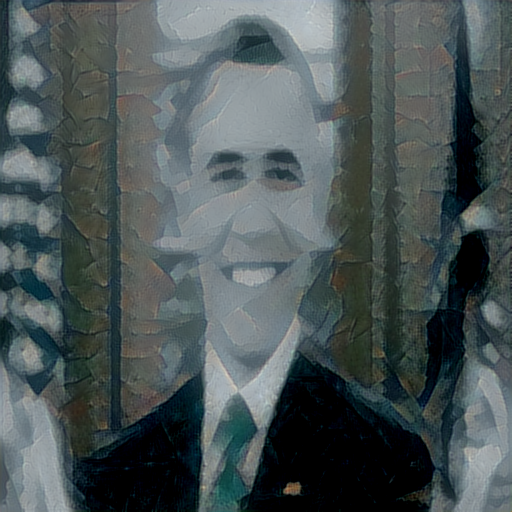

In [278]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)